In [ ]:
!pip install git+https://github.com/uwjunqi/Pytorch-Tensor-Train-Network.git

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tc.tc_fc import TTLinear
import matplotlib.pyplot as plt
import time

from torch.nn.utils import parameters_to_vector

from matplotlib import cm

In [2]:
device = 'cuda'

In [3]:
torch.set_default_device(device)

In [4]:
x_grid = np.linspace(0, 1, 51)
t_grid = np.linspace(0, 1, 51)

x = torch.from_numpy(x_grid)
t = torch.from_numpy(t_grid)

grid = torch.cartesian_prod(x, t).float().to(device)

def nn_autograd_simple(model, points, order,axis=0):
    points.requires_grad=True
    f = model(points).sum()
    for i in range(order):
        grads, = torch.autograd.grad(f, points, create_graph=True)
        f = grads[:,axis].sum()
    return grads[:,axis]

func_bnd1 = lambda x: 10 ** 4 * torch.sin((1 / 10) * x * (x - 1)) ** 2
bnd1 = torch.cartesian_prod(x, torch.from_numpy(np.array([0], dtype=np.float64))).float().to(device)
bndval1 = func_bnd1(bnd1[:, 0])

# du/dx (x,0) = 1e3*sin^2(x(x-1)/10)
func_bnd2 = lambda x: 10 ** 3 * torch.sin((1 / 10) * x * (x - 1)) ** 2
bnd2 = torch.cartesian_prod(x, torch.from_numpy(np.array([0], dtype=np.float64))).float().to(device)
bop2 = {
    'du/dt':
        {
            'coeff': 1,
            'du/dt': [1],
            'pow': 1,
            'var': 0
        }
}
bndval2 = func_bnd2(bnd2[:, 0])

# u(0,t) = u(1,t)
bnd3_left = torch.cartesian_prod(torch.from_numpy(np.array([0], dtype=np.float64)), t).float().to(device)
bnd3_right = torch.cartesian_prod(torch.from_numpy(np.array([1], dtype=np.float64)), t).float().to(device)
bnd3 = [bnd3_left, bnd3_right]

# du/dt(0,t) = du/dt(1,t)
bnd4_left = torch.cartesian_prod(torch.from_numpy(np.array([0], dtype=np.float64)), t).float().to(device)
bnd4_right = torch.cartesian_prod(torch.from_numpy(np.array([1], dtype=np.float64)), t).float().to(device)
bnd4 = [bnd4_left, bnd4_right]

bop4 = {
    'du/dx':
        {
            'coeff': 1,
            'du/dx': [0],
            'pow': 1,
            'var': 0
        }
}
bcond_type = 'periodic'

bconds = [[bnd1, bndval1, 'dirichlet'],
          [bnd2, bop2, bndval2, 'operator'],
          [bnd3, bcond_type],
          [bnd4, bop4, bcond_type]]

def wave_op(model, grid):
    u_xx = nn_autograd_simple(model, grid, order=2, axis=0)
    u_tt = nn_autograd_simple(model, grid, order=2, axis=1)
    a = -(1 / 4)

    op = u_tt + a * u_xx

    return op

def op_loss(operator):
    return torch.mean(torch.square(operator))

def bcs_loss(model):
    bc1 = model(bnd1)
    bc2 = nn_autograd_simple(model, bnd2, order=1, axis=1)
    bc3 = model(bnd3_left) - model(bnd3_right)
    bc4 = nn_autograd_simple(model, bnd4_left, order=1, axis=0) - nn_autograd_simple(model, bnd4_right, order=1, axis=0)
    
    loss_bc1 = torch.mean(torch.square(bc1.reshape(-1) - bndval1))
    loss_bc2 = torch.mean(torch.square(bc2.reshape(-1) - bndval2))
    loss_bc3 = torch.mean(torch.square(bc3))
    loss_bc4 = torch.mean(torch.square(bc4))
    
    loss = loss_bc1 + loss_bc2 + loss_bc3 + loss_bc4
    return loss

In [5]:
def draw_fig(model, grid):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = grid[:, 0].detach().cpu().numpy().reshape(-1)
    ys = grid[:, 1].detach().cpu().numpy().reshape(-1)
    zs = model(grid).detach().cpu().numpy().reshape(-1)

    ax.plot_trisurf(xs, ys, zs, cmap=cm.jet, linewidth=0.2, alpha=1)

    ax.set_title("wave periodic")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")

    plt.show()

In [6]:
def loss_fn(model):
    # model.load_state_dict(params)
    operator = wave_op(model, grid)
    loss = op_loss(operator) + 1000 * bcs_loss(model)
    return loss

In [7]:
model = torch.nn.Sequential(
        nn.Linear(2, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 1)).to(device)

In [8]:
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer
from typing import Callable, Tuple, Union

class ZO_AdaMM(torch.optim.Optimizer):
    """
    Zeroth-order Adam optimizer.

    References:
        - Xiangyi Chen, Sijia Liu, Kaidi Xu, Xingguo Li, Xue Lin, Mingyi Hong, David Cox.
          "ZO-AdaMM: Zeroth-Order Adaptive Momentum Method for Black-Box Optimization."
          ArXiv preprint, abs/1910.06513, 2019.
          URL: https://api.semanticscholar.org/CorpusID:202777327
    """

    def __init__(self, params: torch.Tensor,
                 input_size: int,
                 gradient_mode: str = 'forward',
                 sampler: str = 'uniform',
                 dim: int = 2,
                 lr: float = 1e-3,
                 betas: Tuple[float, float] = (0.9, 0.999),
                 mu: float = 1e-3,
                 eps: float = 1e-12):
        """
        Args:
            params: model parameters
            input_size: size of the input data (i.e. batch size).
            gradient_mode: mode for gradient descent directions (e.g. 'central').
            sampler: random sampling type (uniform, normal).
            dim: problem dimensionality (d = 1 - ODEs, d > 2 - PDEs i.e. t, x, y, z, etc...).
            lr: learning rate.
            betas: coefficients used for computing running averages of gradient and its square.
            mu: perturbation parameter for each direction in gradient size (i.e. standard deviation).
            eps: term added to the denominator to improve numerical stability.
        """
        defaults = dict(lr=lr, betas=betas, mu=mu, eps=eps)
        super().__init__(params, defaults)
        self.input_size = input_size
        self.gradient_mode = gradient_mode
        self.sampler = sampler
        self.n_samples = 1
        self.dim = dim
        self.name = 'ZO_Adam'

        self.size_params = 0
        for group in self.param_groups:
            for p in group['params']:
                self.size_params += torch.numel(p)

    def step(self, closure_zo: Callable = None):
        """
        Performs a single optimization step.

        Args:
            closure: function that computes gradients.
        """
        for group in self.param_groups:
            beta1, beta2 = group['betas']

            # Closure return the approximation for the gradient
            grad_est, loss = closure_zo(size_params=self.size_params, mu=group["mu"],
                               n_samples=self.n_samples, input_size=self.input_size,
                               d=self.dim, sampler=self.sampler, gradient_mode=self.gradient_mode)

            for p, grad in zip(group['params'], grad_est):
                state = self.state[p]

                # Lazy state initialization
                if len(state) == 0:
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                # Do the AdaMM updates
                state['exp_avg'].mul_(beta1).add_(grad, alpha=(1.0 - beta1))
                state['exp_avg_sq'].mul_(beta2).addcmul_(grad, grad, value=(1.0 - beta2))
                state['max_exp_avg_sq'] = torch.maximum(state['max_exp_avg_sq'],
                                                        state['exp_avg_sq'])

                p.data.addcdiv_(state['exp_avg'], state['exp_avg_sq'].sqrt().add_(group['eps']), value=(-group['lr']))

        return loss

In [10]:
from copy import deepcopy
from tedeous.device import check_device

In [29]:
hid = [5, 2, 5, 2]
rank = [1, 2, 2, 2, 1]

model = torch.nn.Sequential(
        nn.Linear(2, 100),
        nn.Tanh(),
        TTLinear(hid, hid, rank, activation=None),
        nn.Tanh(),
        TTLinear(hid, hid, rank, activation=None),
        nn.Tanh(),
        nn.Linear(100, 1)).to(device)

In [30]:
def closure_zo(                size_params: int,
                input_size: int,
                mu: float,
                n_samples: int,
                d: int,
                sampler: str = 'uniform',
                gradient_mode: str = 'central'):
    """
    Closure function for zeroth-order optimizers.

    Args:
        size_params: number of optimization parameters.
                        The calculation occurs automatically. Do not set it manually!
        input_size: size of the input data (i.e. batch size).
        n_samples: set size for gradient descent directions.
        mu: perturbation parameter for each direction in gradient size (i.e. standard deviation).
        d: problem dimensionality (d = 1 - ODEs, d > 2 - PDEs i.e. [t, x, y, z, etc...]).
        sampler: random sampling type.
        gradient_mode: mode for gradient descent directions.

    Returns:
        zeroth-order gradient estimation.
    """
    init_model_parameters = deepcopy(dict(model.state_dict()))
    model_parameters = dict(model.state_dict()).values()

    def parameter_perturbation(eps):
        start_idx = 0
        for param in model_parameters:
            end_idx = start_idx + param.view(-1).size()[0]
            param.add_(eps[start_idx: end_idx].view(param.size()).float(), alpha=np.sqrt(mu))
            start_idx = end_idx

    def grads_multiplication(grads, u):
        start_idx = 0
        grad_est = []
        for param in model_parameters:
            end_idx = start_idx + param.view(-1).size()[0]
            grad_est.append(grads * u[start_idx:end_idx].view(param.size()))
            start_idx = end_idx
        return grad_est

    grads = [torch.zeros_like(param) for param in model_parameters]
    cur_loss = loss_fn(model)

    for _ in range(n_samples):
        with torch.no_grad():
            if sampler == 'uniform':
                u = 2 * (torch.rand(size_params) - 0.5)
                u.div_(torch.norm(u, "fro"))
                u = check_device(u)
            elif sampler == 'normal':
                u = torch.randn(size_params)
                u = check_device(u)

            # param + mu * eps
            parameter_perturbation(u)

        loss_add = loss_fn(model)

        # param - mu * eps
        with torch.no_grad():
            parameter_perturbation(-2 * u)

        loss_sub = loss_fn(model)

        with torch.no_grad():
            if gradient_mode == 'central':
                # (1/ inp_size * q) * d * [f(x+mu*eps) - f(x-mu*eps)] / 2*mu
                grad_coeff = (1 / (input_size * n_samples)) * d * (loss_add - loss_sub) / (2 * mu)
            elif gradient_mode == 'forward':
                # d * [f(x+mu*eps) - f(x)] / mu
                grad_coeff = (1 / (input_size * n_samples)) * d * (loss_add - cur_loss) / mu
            elif gradient_mode == 'backward':
                # d * [f(x) - f(x-mu*eps)] / mu
                grad_coeff = (1 / (input_size * n_samples)) * d * (cur_loss - loss_sub) / mu

            # coeff * u, i.e. constant multiplied by infinitely small perturbation.
            current_grad = grads_multiplication(grad_coeff, u)

            grads = [grad_past + cur_grad for grad_past, cur_grad in zip(grads, current_grad)]

        # load initial model parameters
        model.load_state_dict(init_model_parameters)

    return grads, cur_loss

In [31]:
config = {
    "seed": 42,
    "batch_size": 128,
    "net": "scalable",
    "scale": 1.0/9,
    "opt_params": [1e-3, 0.9, 0.999, 1e-8],
    "optimizer": 'ZO-AdaMM',
    "epochs": 50,
    "dataset": "mnist",
    "zo_optim": True,
    "mu": 1e-3,
    "use_scheduler": True,
    "verbose": True
}

optimizer = ZO_AdaMM(model.parameters(), input_size=len(grid),lr=config['opt_params'][0],
                             betas=(config['opt_params'][1], config['opt_params'][2]),
                             eps=config['opt_params'][3],
                             mu=config['mu'], sampler='uniform')

In [25]:
hid = [5, 2, 5, 2]
rank = [1, 2, 2, 2, 1]

model = torch.nn.Sequential(
        nn.Linear(2, 100),
        nn.Tanh(),
        TTLinear(hid, hid, rank, activation=None),
        nn.Tanh(),
        TTLinear(hid, hid, rank, activation=None),
        nn.Tanh(),
        nn.Linear(100, 1)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.optim.lr_scheduler import ExponentialLR
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [32]:
print(model)
for i in range(10001):
    optimizer.zero_grad()
    loss = loss_fn(model)
    # loss.backward()
    if i % 1000 == 0:
        print(loss.item())
    optimizer.step(closure_zo)
    # if i % 1000 == 0:
    #     scheduler.step()

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Tanh()
  (2): TTLinear(
    (TTLayer): inp_modes=[5, 2, 5, 2], out_modes=[5, 2, 5, 2], mat_ranks=[1, 2, 2, 2, 1]
    (W_cores): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1x5x5x2 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 2x2x2x2 (cuda:0)]
        (2): Parameter containing: [torch.float32 of size 2x5x5x2 (cuda:0)]
        (3): Parameter containing: [torch.float32 of size 2x2x2x1 (cuda:0)]
    )
  )
  (3): Tanh()
  (4): TTLinear(
    (TTLayer): inp_modes=[5, 2, 5, 2], out_modes=[5, 2, 5, 2], mat_ranks=[1, 2, 2, 2, 1]
    (W_cores): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1x5x5x2 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 2x2x2x2 (cuda:0)]
        (2): Parameter containing: [torch.float32 of size 2x5x5x2 (cuda:0)]
        (3): Parameter containing: [torch.float32 of size 2x2x2x1 (cuda:0)]
    )
  )
  

In [27]:
def draw_fig(model, grid):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = grid[:, 0].detach().cpu().numpy().reshape(-1)
    ys = grid[:, 1].detach().cpu().numpy().reshape(-1)
    zs = model(grid).detach().cpu().numpy().reshape(-1)

    ax.plot_trisurf(xs, ys, zs, cmap=cm.jet, linewidth=0.2, alpha=1)

    ax.set_title("wave periodic")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")

    plt.show()

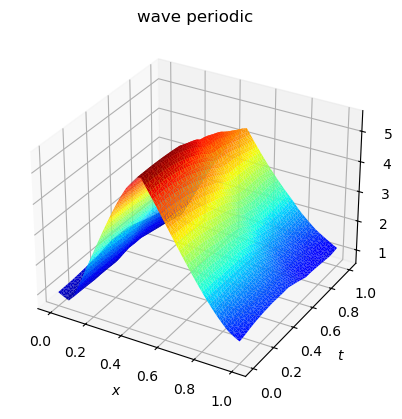

In [28]:
draw_fig(model, grid)